## 안면인식 만들기

### 과제 설명 

##### face detection 구현하기
1. 과제1에서 제출한 사진을 이용할 것
2. 3주차에서 배운 영상처리를 이용해서 얼굴 영역 분할하기(hsv color segmentation) => 얼굴 영역 mask 이미지
3. 분할된 얼굴 영역을 포함하는 사각형 박스(bounding box) 좌표 얻기 => detection 결과
4. 얼굴 영역은 mask 로 표현하고 사각형 박스는 cv2.rectangle() 을 이용해서 이미지에 그리기 => 최종 이미지
##### 4주차에 배운 face detection 과 face recognition 직접 실행하기
1. 과제1에서 제출한 사진을 이용할 것 + 추가로 과제 수행하는 날짜의 사진을 촬영할 것 (2장 이상으로 해야함)
2. 두 개 이상의 본인 사진을 이용해 face recognition 을 수행하고 얼마나 비슷한 embedding 값을 가지는지 확인할 것 => embedding 의 L2 norm 또는 cos similarity 출력
3. dlib detector 대신 직접 구현한 color segmentation mask 기반의 detector 로 수정해서 face recognition 을 재실행하고 detector 가 달라짐에 따라 같은 이미지의 embedding 이 달라지는지 2번과 같은 방식으로 확인하기
4. dlib detector 와 color segmentation mask detector 의 결과가 어떻게 다른지 비교하고 둘 중 어떤 detector 를 수정해야할지 작성하기
5. 각 방법의 실행시간 비교하기

#### 폴더 디렉토리 


root
├── models
├── images
    ├── my_face_*.jpg
		└── image.jpg
└── code.ipynb


#### 라이브러리 설치하기

In [1]:
%pip install opencv-python
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install torchvision
%pip install PIL



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [2]:
%pip install dlib-19.22.99-cp39-cp39-win_amd64.whl

Processing c:\users\trixy\pythonimageworkspace\생체인증보안week2\dlib-19.22.99-cp39-cp39-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\trixy\\PythonImageWorkspace\\생체인증보안week2\\dlib-19.22.99-cp39-cp39-win_amd64.whl'



In [3]:
%pip install cmake
%pip install opencv-contrib-python dlib

  Using cached cmake-3.26.1-py2.py3-none-win_amd64.whl (33.0 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install numpy pandas opencv-python face-recognition
!git clone https://github.com/ageitgey/face_recognition.git

Note: you may need to restart the kernel to use updated packages.


fatal: destination path 'face_recognition' already exists and is not an empty directory.


##### 라이브러리 불러오기

In [6]:
import os
import torch
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
import dlib




In [7]:
import face_recognition

##### 데이터 불러오기 

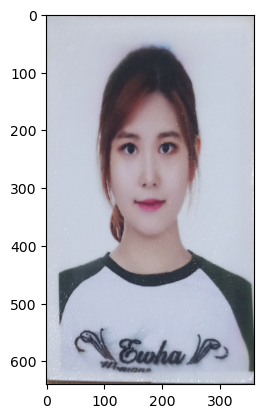

In [8]:
img_bgr = cv2.imread('./images/train.jpg')
img_bgr = cv2.resize(img_bgr, (360,640))
img_show = img_bgr.copy()
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

In [9]:
#이미지 타입 확인
print(img_show.shape)
print(img_show.dtype)
print(type(img_show))

(640, 360, 3)
uint8
<class 'numpy.ndarray'>


#### 데이터 전처리하기 

##### 얼굴 영역 분할하기 

In [10]:
# 색상+명도+채도 모두 고려해서 얼굴을 추출하기 힘듦
# 색상과 채도를 없애버리고 명도만 준다면...? -> 훨씬 추출하기 쉽지 않을까?
# 색상, 채도를 default로 둔 뒤에 하나의 parameter만 가지고 upper_range~lower_range로 설정 -> mask 만들기 -> mask 출력





[[[166 174 190]
  [169 175 187]
  [186 187 189]]

 [[168 176 190]
  [174 178 189]
  [188 186 188]]

 [[174 183 196]
  [170 172 182]
  [191 188 189]]]


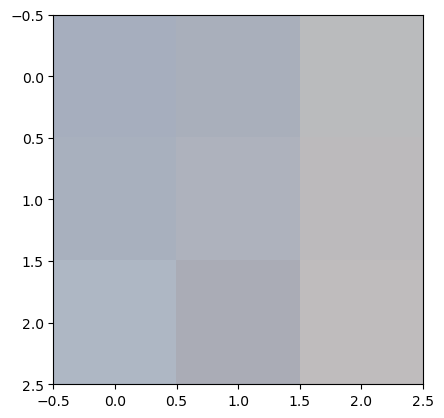

In [11]:
print(img_show[:3, :3])
plt.imshow(img_show[:3, :3])


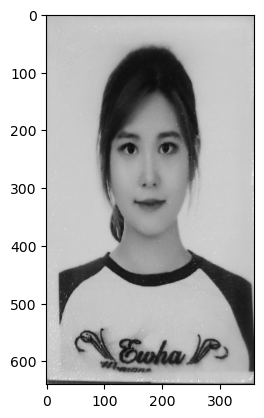

In [12]:
# color default 두기
img_gray = cv2.cvtColor(img_show, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,  cmap='gray')

#### 데이터 전처리

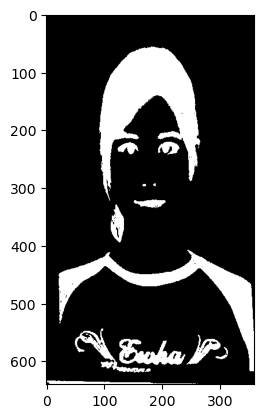

In [13]:
img_zero = np.zeros((640, 360), dtype=np.uint8) #크기가 360x640인, 데이터 타입이 uint8인 2차원 배열,  모든 원소는 0으로 초기화
img_zero[img_gray > 110] = 255 #img_gray 이미지에서 픽셀 값이 110보다 큰 부분은 img_zero 이미지의 해당 위치의 값을 255(흰색)으로 바꾼다. 즉, img_gray 이미지에서 밝기 값이 210보다 큰 부분이 흰색으로 표시된다.
img_src = 255 - img_zero #이미지에서 255(흰색)에서 각 픽셀 값만큼을 뺀 결과를 img_src 이미지로 저장함 ->img_gray 이미지에서 밝기 값이 210보다 큰 부분은 검정색(0)으로, 그 외의 부분은 흰색으로 변환함
plt.imshow(img_src, cmap='gray') #그레이 스케일로 시각화함 

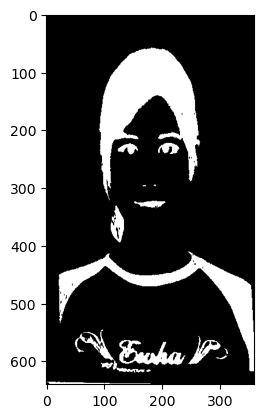

In [14]:
img_erode = cv2.erode(img_src, (10, 10))
img_erode = cv2.erode(img_erode, (10, 10))
plt.imshow(img_erode, cmap='gray')

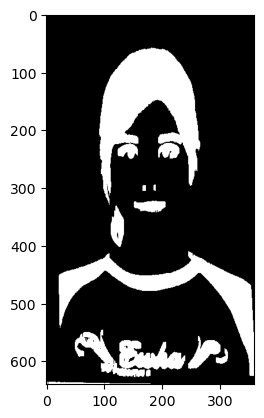

In [15]:
img_dil = cv2.dilate(img_erode, (15, 15), iterations=8)


plt.imshow(img_dil, cmap='gray')

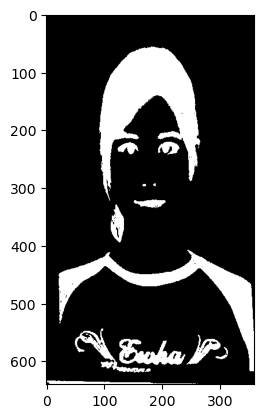

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
img_morph = cv2.morphologyEx(img_src, cv2.MORPH_OPEN, kernel, iterations=1)
img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_CLOSE, kernel, iterations=37)

plt.imshow(img_morph, cmap='gray')

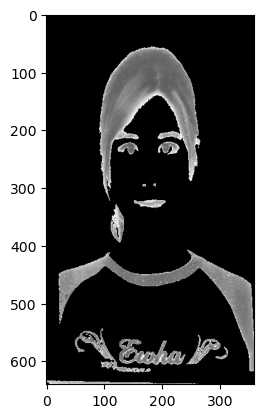

In [17]:
img_threshold = np.zeros_like(img_gray)
# img_threshold[img_morph == 255] = img_gray
img_threshold = np.where(img_morph == 255, img_gray, 0)

plt.imshow(img_threshold, cmap='gray')

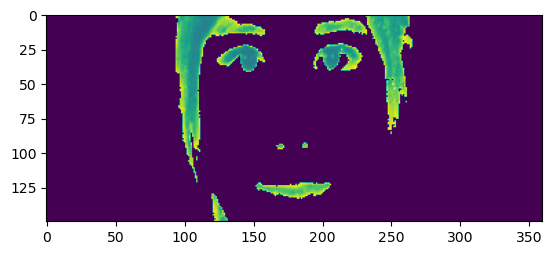

In [18]:
img_threshold = img_threshold[200:350,:]
lower_range = 0
upper_range=100

mask = cv2.inRange(img_threshold, lower_range, upper_range)

face_segmented = cv2.bitwise_and(img_threshold, img_threshold, mask=mask)
plt.imshow(face_segmented)

In [19]:
##### 바운딩 박스 얻기

In [20]:
detector_hog = dlib.get_frontal_face_detector() # detector 선언

In [21]:
img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_bgr, 1)

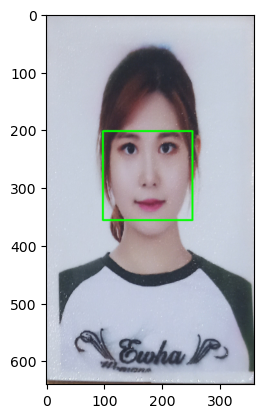

In [22]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_bgr, (l,t), (r,b), 
									(0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_bgr)
plt.show()

In [23]:
%pip install --upgrade face_recognition

Note: you may need to restart the kernel to use updated packages.


In [26]:
# 얼굴벡터 찾기
from face_recognition import face_locations
locations = face_locations(img_bgr)
print(locations)

[(167, 291, 390, 68)]


##### train 이미지 임포트하기 

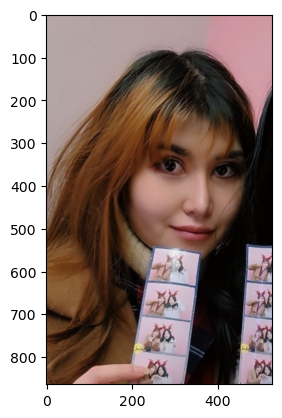

In [32]:
file_path = os.path.join('images', 'test.jpg')
img_test = cv2.imread(file_path)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB) )

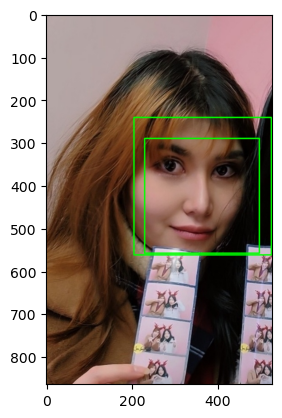

In [36]:
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_test, 1)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_test, (l,t), (r,b), 
									(0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_test)
plt.show()


In [ ]:
image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']

# 이미지 파일 경로 리스트를 이용하여 각 이미지의 얼굴 embedding 추출
face_embeddings = []
for image_path in image_paths:
    image = face_recognition.load_image_file(image_path)
    face_embedding = face_recognition.face_encodings(image)[0]
    face_embeddings.append(face_embedding)

# 얼굴 embedding 값 비교 및 출력
for i in range(len(face_embeddings)):
    for j in range(i+1, len(face_embeddings)):
        embedding_i = face_embeddings[i]
        embedding_j = face_embeddings[j]
        l2_distance = face_recognition.face_distance([embedding_i], embedding_j)[0]
        cosine_similarity = face_recognition.face_distance([embedding_i], embedding_j)[0]
        print(f"Image {i+1} and Image {j+1} - L2 Distance: {l2_distance}, Cosine Similarity: {cosine_similarity}")





